## Домашнее задание
1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

Подключаемся к google disc

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Распаковываем архив

In [32]:
! unzip '/content/drive/MyDrive/Twitter Sentiment Analysis.zip'

Archive:  /content/drive/MyDrive/Twitter Sentiment Analysis.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Смотрим на данные

In [33]:
import pandas as pd

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [38]:
df_train[df_train['label']==0].head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [40]:
df_train[df_train['label']==1].head(7)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...


0 - positive<br>
1 - negative

In [43]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [45]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


##Предобработка

In [46]:
!pip install stop-words pymorphy2

     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 8.2 MB 11.2 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=e493571226814777ecb58d71fe2c46859564e46c1602f960c45e51cca79a43d8
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [47]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

Сохраняем в переменные стоп-слова и знаки пунктуации

In [52]:
sw = set(get_stop_words("en"))
#sw

In [53]:
puncts = set(punctuation)

Создаем функцию по очистке твитов от стоп-слов, знаков пунктуации приводим всё в нижний регистр

In [58]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [67]:
print(df_train['tweet'].iloc[:1])

0     @user when a father is dysfunctional and is s...
Name: tweet, dtype: object


In [68]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['user father dysfunctional selfish drags kids dysfunction run'],
      dtype=object)

Разбиваем обучающую выборку на трейн и валидацию

In [72]:
from sklearn.model_selection import train_test_split

def train_valid_split(Xt):
    df_train, df_val = train_test_split(Xt, test_size=0.15, random_state=13)
    return df_train, df_val

In [73]:
df_train, df_val = train_valid_split(df_train)

In [74]:
df_train['label'].value_counts()

0    25250
1     1917
Name: label, dtype: int64

In [75]:
df_val['label'].value_counts()

0    4470
1     325
Name: label, dtype: int64

Структура лейблов в тренировочной и валидационной выборке примерно одинакова

Делаем препроцессинг текстов в трейне и валидации

In [76]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 4795/4795 [00:01<00:00, 3969.83it/s]


Создаем корпус слов, на котором будем обучаться

In [79]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
#train_corpus

Разбиваем весь корпус на токены

In [80]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['thankful', 'sense', 'touch', 'thankful', 'positive']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [81]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [83]:
from nltk.probability import FreqDist

max_words = 2500
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2499

In [84]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'im', 'u', 'time']

Соберем словарь из самых популярных токенов, где каждому токену будет присвоен уникальный индекс

In [85]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'happy': 4,
 'amp': 5,
 'just': 6,
 'will': 7,
 'im': 8,
 'u': 9,
 'time': 10,
 'life': 11,
 'like': 12,
 'today': 13,
 'now': 14,
 'new': 15,
 'thankful': 16,
 'get': 17,
 'positive': 18,
 'people': 19,
 'good': 20,
 'bihday': 21,
 'cant': 22,
 'see': 23,
 'one': 24,
 'can': 25,
 'fathers': 26,
 'dont': 27,
 'smile': 28,
 'go': 29,
 'want': 30,
 'take': 31,
 'healthy': 32,
 'work': 33,
 'got': 34,
 'weekend': 35,
 'fun': 36,
 'make': 37,
 'summer': 38,
 'need': 39,
 'bull': 40,
 'best': 41,
 'family': 42,
 'friday': 43,
 'us': 44,
 'way': 45,
 '2': 46,
 'great': 47,
 'beautiful': 48,
 'days': 49,
 'first': 50,
 'going': 51,
 'friends': 52,
 'really': 53,
 'wait': 54,
 'music': 55,
 'fathersday': 56,
 'morning': 57,
 'know': 58,
 'back': 59,
 'world': 60,
 'never': 61,
 'orlando': 62,
 'week': 63,
 'sad': 64,
 'tomorrow': 65,
 'cute': 66,
 'think': 67,
 'feel': 68,
 'blog': 69,
 'well': 70,
 'happiness': 71,
 'much': 72,
 'trump': 73,
 'model': 74,
 

Создадим функцию по созданию из твитов последовательностей заданной длины

In [88]:
import numpy as np
max_len = 20

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

Переведем трейн и валидационную выборку в наборк последовательностей

In [89]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 3.84 s, sys: 3.82 ms, total: 3.85 s
Wall time: 3.86 s


In [90]:
df_train['tweet'].iloc[0]

'thankful sense touch thankful positive'

In [91]:
x_train[0]

array([  16,  895, 1406,   16,   18,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

Создаем архитектуру нейронной сети

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

Создаем кастомный класс Датасета

In [93]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Создаем из наших данных кастомные датасеты и создаем лоадеры

In [96]:
batch_size = 128

train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

Создаем модель

In [97]:
model = Net(vocab_size=max_words)
device = 'cpu'

In [98]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2500, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 410497


Функция ошибки и оптимизатор

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

Запускаем обучение

In [101]:
model = model.to(device)
model.train()
th = 0.5
epochs = 5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(val_loader):
                test_labels = data[1].to(device)
                test_outputs = model(data[0].to(device))
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            test_loss_history.append(test_loss.item())
            print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/5]. Step [1/213]. Loss: 0.728. Acc: 0.141. Test loss: 0.028. Test acc: 0.932
Epoch [1/5]. Step [151/213]. Loss: 0.121. Acc: 0.936. Test loss: 0.017. Test acc: 0.950
Epoch [2/5]. Step [1/213]. Loss: 0.196. Acc: 0.945. Test loss: 0.053. Test acc: 0.955
Epoch [2/5]. Step [151/213]. Loss: 0.078. Acc: 0.962. Test loss: 0.053. Test acc: 0.954
Epoch [3/5]. Step [1/213]. Loss: 0.078. Acc: 0.969. Test loss: 0.003. Test acc: 0.957
Epoch [3/5]. Step [151/213]. Loss: 0.043. Acc: 0.975. Test loss: 0.000. Test acc: 0.955
Epoch [4/5]. Step [1/213]. Loss: 0.025. Acc: 0.992. Test loss: 0.070. Test acc: 0.956
Epoch [4/5]. Step [151/213]. Loss: 0.040. Acc: 0.980. Test loss: 0.000. Test acc: 0.956
Epoch [5/5]. Step [1/213]. Loss: 0.013. Acc: 1.000. Test loss: 0.031. Test acc: 0.953
Epoch [5/5]. Step [151/213]. Loss: 0.097. Acc: 0.987. Test loss: 0.000. Test acc: 0.946
Training is finished!


Метрики очень хорошие получились, но есть небольшое переобучение

Отрисуем изменение функции ошибки

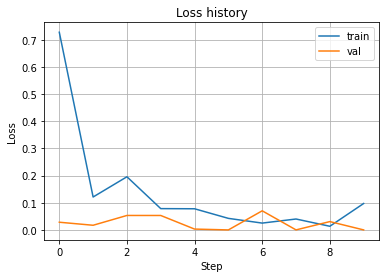

In [129]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='val')
plt.legend();

Сделаем предсказание на тестовых данных

Переведем тестовые данные в последовательности

In [104]:
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])

Переведем данные из numpy array в pytorch tensor

In [110]:
x_test

array([[1253,  100,    0, ...,    0,    0,    0],
       [   1,  159,   30, ...,    0,    0,    0],
       [ 555,  848,  695, ...,    0,    0,    0],
       ...,
       [ 668,   13,  330, ...,    0,    0,    0],
       [   4,   33,  313, ...,    0,    0,    0],
       [ 327,  678,  105, ...,    0,    0,    0]])

In [111]:
x_test = torch.tensor(x_test)

In [112]:
x_test

tensor([[1253,  100,    0,  ...,    0,    0,    0],
        [   1,  159,   30,  ...,    0,    0,    0],
        [ 555,  848,  695,  ...,    0,    0,    0],
        ...,
        [ 668,   13,  330,  ...,    0,    0,    0],
        [   4,   33,  313,  ...,    0,    0,    0],
        [ 327,  678,  105,  ...,    0,    0,    0]])

In [116]:
x_test.shape

torch.Size([17197, 20])

Делаем предикт

In [118]:
predict = model(x_test)
pred_labels = torch.squeeze((predict > th).int())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [122]:
pred_labels.shape

torch.Size([17197])

In [123]:
pred_labels

tensor([0, 1, 0,  ..., 0, 0, 0], dtype=torch.int32)

In [127]:
df_test['labels'] = np.array(pred_labels)
df_test.head()

,id,tweet,labels
0,31963,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0


In [128]:
df_test['labels'].value_counts()

0    16350
1      847
Name: labels, dtype: int64

К сожалению, нет данных, чтобы проверить метрику на тесте